# Compare model output with ASTE and observations

Load selected mooring time series and plot CANARI LE, ASTE and obs (see choose_ASTE_profiles and subset_CANARI_LE)

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import utils
import pickle

In [2]:
%matplotlib inline

Load ASTE data

In [5]:
import glob
mooring_files=glob.glob('../data/*tseries.nc')
mooring_vars={}
for file in mooring_files:
    mooring=xr.open_dataset(file)
    if 'iPROF' in mooring.dims:
        mooring=mooring.swap_dims({'iPROF':'time'})
    mooring=mooring.sortby('time').squeeze()
    if 'point' in mooring.dims:
        for ip,point in enumerate(mooring.point):
            mooring_vars[f'{mooring["loc"].values}_{ip}']=mooring[['prof_T','prof_Testim','prof_S','prof_Sestim']].sel(point=point)
    else:
        mooring_vars[str(mooring['loc'].values)]=mooring[['prof_T','prof_Testim','prof_S','prof_Sestim']]

Load CANARI LE data

In [17]:
Tdata_allm=xr.open_mfdataset(f'../data/mooring_tseries*nc',concat_dim='ens',combine='nested')
Tdata_allm=Tdata_allm.assign_coords({'loc':['Beaufort Mooring', 'Bering Mooring', 'Davis Mooring', 'Fram Mooring',
       'OSNAP Mooring_0', 'OSNAP Mooring_1']})

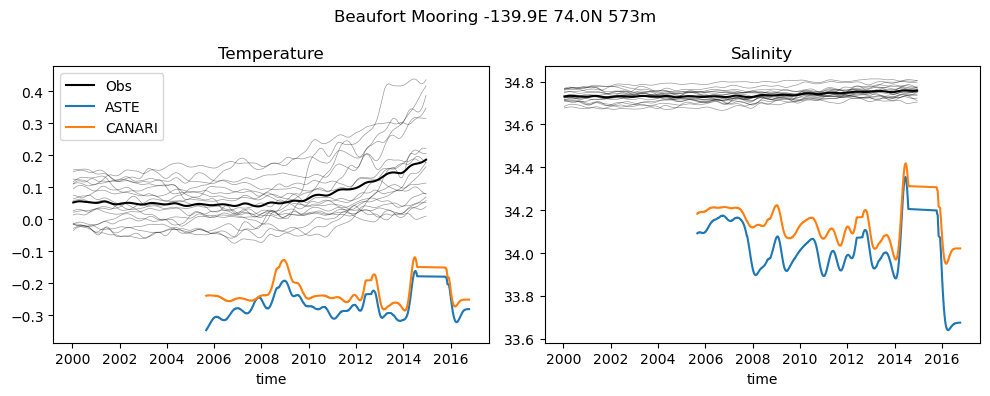

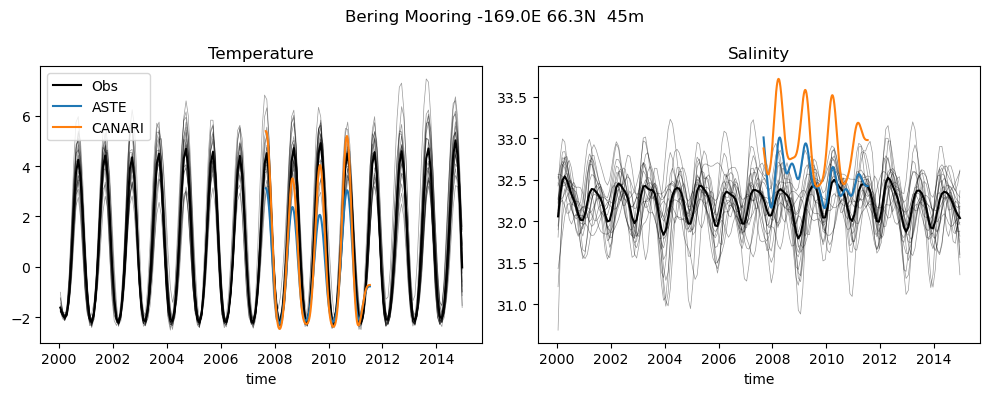

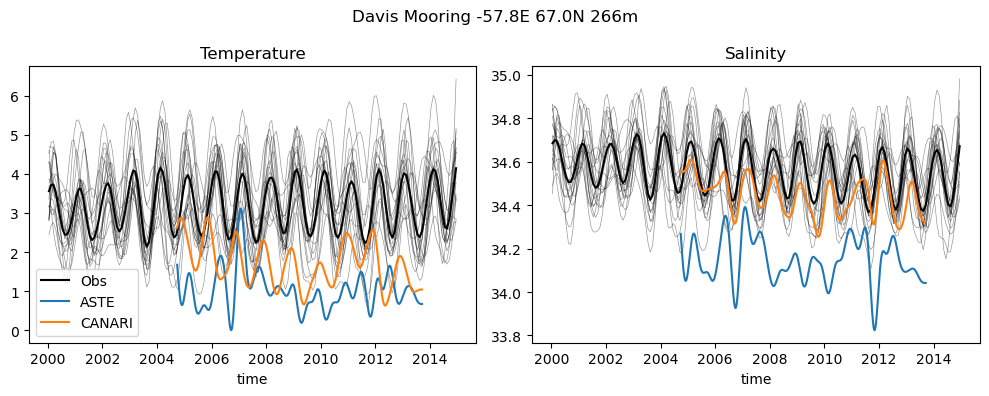

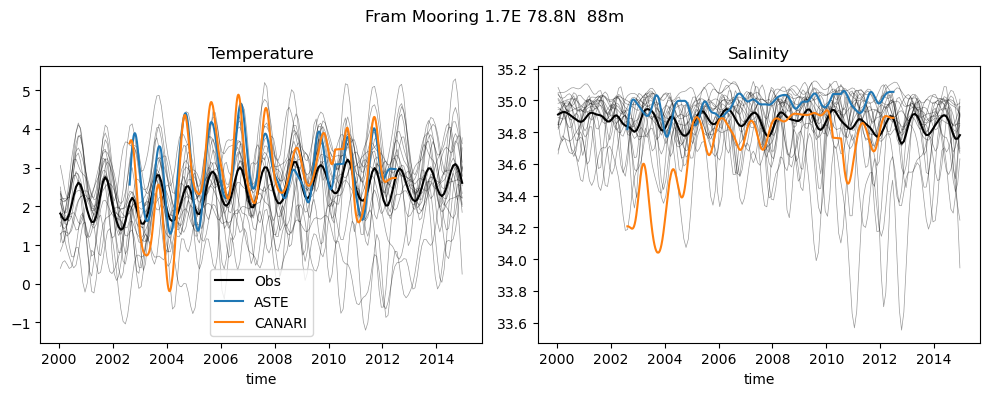

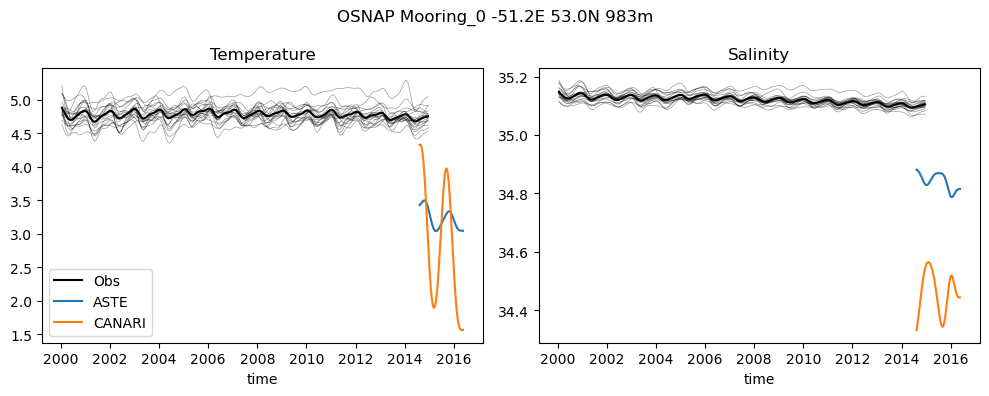

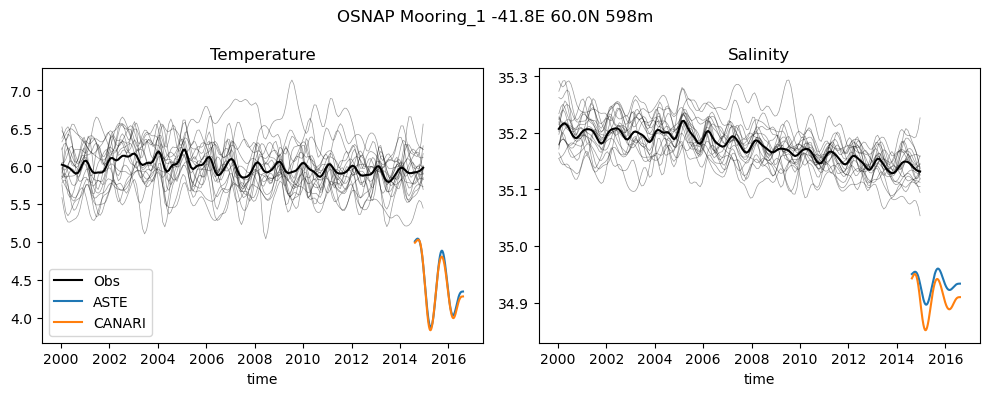

In [30]:
for loc in mooring_vars:
    plt.figure(figsize=[10,4])
    plt.subplot(1,2,1)
    Tdata_plot=Tdata_allm.sel(loc=loc)
    utils.butter_ufunc(Tdata_plot.votemper.dropna('time_counter').load(),6,'time_counter').plot(x='time_counter',hue='ens',color='k',linewidth=0.5,add_legend=False,alpha=0.4)
    pp1=utils.butter_ufunc(Tdata_plot.votemper.dropna('time_counter').mean('ens').load(),6,'time_counter').plot(x='time_counter',hue='ens',color='k',add_legend=False)
    pp2=utils.butter_ufunc(mooring_vars[loc].prof_T.dropna('time'),365.25/2,'time').plot(x='time')
    pp3=utils.butter_ufunc(mooring_vars[loc].prof_Testim.dropna('time'),365.25/2,'time').plot(x='time')
    plt.legend([pp1[0],pp2[0],pp3[0]],['Obs','ASTE','CANARI'])
    plt.title('Temperature')
    plt.ylabel('')
    plt.subplot(1,2,2)
    utils.butter_ufunc(Tdata_plot.vosaline.dropna('time_counter').load(),6,'time_counter').plot(x='time_counter',hue='ens',color='k',linewidth=0.5,add_legend=False,alpha=0.4)
    utils.butter_ufunc(Tdata_plot.vosaline.dropna('time_counter').mean('ens').load(),6,'time_counter').plot(x='time_counter',hue='ens',color='k',add_legend=False)
    utils.butter_ufunc(mooring_vars[loc].prof_S.dropna('time'),365.25/2,'time').plot(x='time')
    utils.butter_ufunc(mooring_vars[loc].prof_Sestim.dropna('time'),365.25/2,'time').plot(x='time')
    plt.title('Salinity')
    plt.ylabel('')
    plt.suptitle(f'{loc} {Tdata_plot.nav_lon.data:2.1f}E {Tdata_plot.nav_lat.data:2.1f}N {Tdata_plot.deptht.data:3.0f}m')
    plt.tight_layout()
    plt.savefig(f'../plots/{loc}_mooring_tseries.png',bbox_inches='tight')